## import modules

In [3]:
# Import basic modules
# More modules will be imported before the corresponding function
# import logging # logger = logging.getLogger(__name__)
import math
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Ignore some annoying warnings
from datetime import datetime

# Import module for EMD decomposition
# It is the EMD-signal module with different name to import
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation #For module 'PyEMD', please use 'pip install EMD-signal' instead.

# Import modules for LSTM prediciton
# Sklearn
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_absolute_percentage_error # MAPE
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.layers import GRU,Flatten
#from tcn import TCN # pip install keras-tcn

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model # To use plot_model, you need to install software graphviz
from tensorflow.python.client import device_lib

# Statistical tests
from statsmodels.tsa.stattools import adfuller # adf_test
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test # LB_test
from statsmodels.stats.stattools import jarque_bera as jb_test # JB_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot_acf_pacf

from sklearn.preprocessing import StandardScaler

import yfinance as yf

import keras

In [ ]:
import pickle

In [227]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   

In [228]:
startdate_training = '2012-04-01'
enddate_training = '2020-03-16'

datasource = 'SPY'
data = yf.download(datasource,start = startdate_training,end = enddate_training)

[*********************100%***********************]  1 of 1 completed


In [229]:
data = data[['Close']]
data

,Close
Date,
2012-04-02,141.839996
2012-04-03,141.259995
2012-04-04,139.860001
2012-04-05,139.789993
2012-04-09,138.220001
...,...
2020-03-09,274.230011
2020-03-10,288.420013
2020-03-11,274.359985


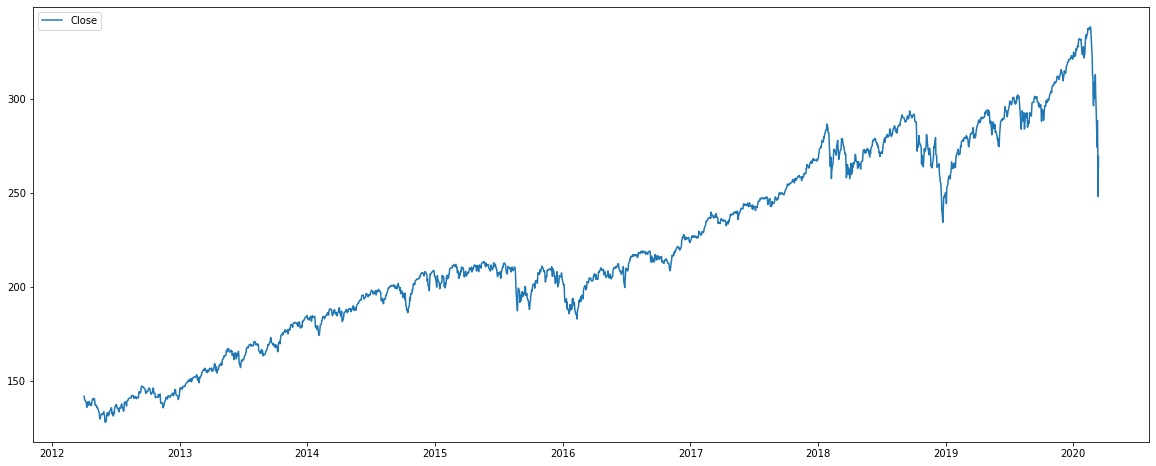

In [230]:
plt.figure(figsize = (20,8))
plt.plot(data['Close'],label = 'Close')
plt.legend()

# 2. EMD decompose data

In [231]:
SERIES = pd.Series(data['Close'].values)

In [232]:
# 3.Decomposition, Sample entropy, Re-decomposition, and Integration
# EMD decomposition
# -------------------------------
# Decompose adaptively and plot function
# Residue is named the last IMF
def emd_decom(series,trials=10,draw=True): 
    # Check input
    series = series.values

    # Initialization
    print('%s decomposition is running.'%str.upper(MODE))
    if MODE == 'emd':decom = EMD()
    elif MODE == 'eemd':decom = EEMD()
    elif MODE == 'ceemdan':decom = CEEMDAN()
        
    # Decompose
    decom.trials = trials # Number of the white noise input
    imfs_emd = decom(series)
    imfs_num = np.shape(imfs_emd)[0]

    if draw:
        # Plot original data
        series_index = range(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_emd[i, :], color='#F27F19')
            plt.ylabel(str.upper(MODE)+'-IMF'+str(i))
    
    imfs_df = pd.DataFrame(imfs_emd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

In [233]:
# VMD # There are some problems in this module
# -------------------------------
def vmd_decom(series,alpha=2000,tau=0,K=5,DC=0,init=1,tol=1e-7,re_decom=True,re_imf=0,draw=True):
    # Check input
    dataset= series
    
    from vmdpy import VMD  
    # VMD parameters
    #alpha = 2000       # moderate bandwidth constraint  
    #tau = 0.           # noise-tolerance (no strict fidelity enforcement)  
    #K = 3              # 3 modes  
    #DC = 0             # no DC part imposed  
    #init = 1           # initialize omegas uniformly  
    #tol = 1e-7         

    # VMD 
    imfs_vmd, imfs_hat, omega = VMD(series, alpha, tau, K, DC, init, tol)  
    imfs_num = np.shape(imfs_vmd)[0]
    
    if draw:
        # Plot original data
        series_index = range(len(series))
        print(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('VMD Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_vmd[i, :], color='#F27F19')
            plt.ylabel('VMD-IMF'+str(i))
            
        plt.show()
    
    # Save data
    imfs_df = pd.DataFrame(imfs_vmd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

In [234]:
# Re-decomposition
# -------------------------------
# re_list is the IMF for re-decomposition
def re_decom(df,redecom_mode='ceemdan',redecom_list=[0],draw=True,trials=10,imfs_num=5): 
    # Check inputs
    if isinstance(redecom_list, int): redecom_list=[redecom_list] # if redecom_list is int
    df_emd = df

    col_name = df_emd.columns[0][:-1] # get the IMF name, such as co-imf, imf, co-imf-re
    
    # Name the dataset file and change MODE like co-imf0-re0 
    global MODE
    tmp_mode = MODE # for saving 
    redecom_mode = str.lower(redecom_mode)
    if redecom_mode == 'emd': 
        redecom_file_name,MODE = 're','emd'# co-imf0-re0 
    elif redecom_mode == 'eemd': 
        redecom_file_name,MODE = 'ree','eemd'# co-imf0-ree0 
    elif redecom_mode == 'ceemdan': 
        redecom_file_name,MODE = 'rce','ceemdan'# co-imf0-rce0 
    elif redecom_mode == 'vmd':
        redecom_file_name = 'rv' # co-imf0-rv0 

    # Re-decompose and create dataset
    redecom_list.sort()
    redecom_imfs_name = '-'+redecom_file_name # new imfs name
    df_redecom = df_emd.copy(deep=True)
    ori_col_names = list(df_emd.columns) # col_names
    df_col_location = 1 # change columns location if re-decompose multiple IMFs
    for i in redecom_list:
        if not isinstance(i, int): raise ValueError('redecom_list must be a list like [0,1] or an integer like 0 or 1.')
        redecom_file_name = redecom_file_name+str(i) # file name
        print('Re-decomposition is running for %s.'%(col_name+str(i)))

        # Re-decompose (figure is saved with name)
        if redecom_mode == 'vmd': df_redecom_ans = vmd_decom(df_emd[col_name+str(i)],re_imf=i,K=imfs_num,draw=draw)
        else: df_redecom_ans = emd_decom(df_emd[col_name+str(i)],trials=trials,draw=draw) # use emd_decom()
        
        df_redecom_ans.columns = [col_name+str(i)+redecom_imfs_name+str(x) for x in range(len(df_redecom_ans.columns))]
        
        # Abandon the original IMF and insert the re-decomposed value
        df_redecom = df_redecom.drop(col_name+str(i), axis=1, inplace=False) # delete original IMF
        df_col_location = i + df_col_location - 1
        ori_col_names.pop(df_col_location) # delete corresponding name
        df_redecom = pd.concat([df_redecom, df_redecom_ans],axis=1)
        
        # Change order for co-imf0-re0 
        ori_col_names[df_col_location:df_col_location] = df_redecom_ans.columns # List of column names in the correct order
        df_col_location = df_col_location + len(df_redecom_ans.columns) - i
        df_redecom = df_redecom.reindex(columns=ori_col_names)

    # Save data and revert MODE
    MODE =  tmp_mode # for saving 
   

    return df_redecom # pd.DataFrame

EMD decomposition is running.
Re-decomposition is running for imf0.
2000


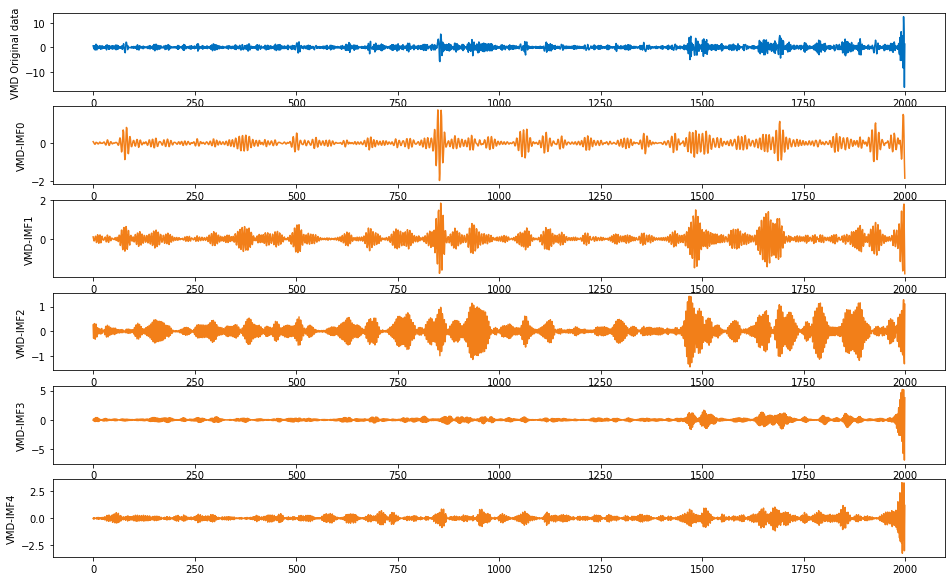

In [235]:
MODE = 'emd'
imfs = emd_decom(SERIES[:],draw = False)
re_imfs = re_decom(imfs,redecom_mode='vmd')

In [236]:
re_imfs

,imf0-rv0,imf0-rv1,imf0-rv2,imf0-rv3,imf0-rv4,imf1,imf2,imf3,imf4,imf5,imf6,imf7
0,0.074158,0.108412,0.255534,-0.053875,-0.017632,1.305455,0.256195,-0.774331,4.109400,0.111882,-17.975941,154.186528
1,0.043593,0.001334,-0.281032,0.164928,0.051986,1.436832,0.181233,-0.855148,4.138096,0.086590,-18.005531,154.203200
2,0.002460,-0.097431,-0.221083,-0.185204,-0.068401,0.993064,0.014575,-0.925126,4.147416,0.062552,-18.034579,154.220009
3,-0.032771,-0.094668,0.312185,0.000955,0.057031,-0.054256,-0.221911,-0.980591,4.136735,0.039776,-18.063080,154.236956
4,-0.062838,-0.011743,0.185309,0.273599,-0.019135,-1.009122,-0.499821,-1.017868,4.105451,0.018243,-18.091033,154.254041
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.518711,-0.347064,0.794025,-5.713685,-0.023186,-2.244216,-14.469056,-12.109073,-0.781761,16.713110,18.735901,276.819546
1996,1.442143,1.635487,1.278278,5.156337,-2.037828,-6.301220,-16.178041,-12.757742,-0.961673,16.555070,18.704253,276.839349
1997,0.420410,1.792106,-0.926717,1.780488,3.288520,-11.865510,-17.234372,-13.184151,-1.119386,16.393442,18.672282,276.859039
1998,-0.972468,-0.038877,-1.318266,-6.859330,-3.008105,-15.305128,-17.387388,-13.363960,-1.253388,16.228263,18.639990,276.878618


# Multi-LSTM

In [237]:
SERIES

0       141.839996
1       141.259995
2       139.860001
3       139.789993
4       138.220001
           ...    
1995    274.230011
1996    288.420013
1997    274.359985
1998    248.110001
1999    269.320007
Length: 2000, dtype: float64

In [238]:
# Model evaluation function
def evl(y_test, y_pred): # MSE and MAE are different on different scales
    y_test,y_pred = np.array(y_test).ravel(),np.array(y_pred).ravel()
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    print('Model Evaluation ')
    print('R2:', r2)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print("MAPE:",mape) # MAPE before normalization may error beacause of negative values
    return [r2,rmse,mae,mape]

In [239]:
# Plot original data and forecasting data
def plot_all(pred_ans,PERIODS):
    # Check and Change
    pred_ans = pred_ans.ravel()
    og = pd.Series(SERIES[-PERIODS:].values)

    # Plot
    fig = plt.figure(figsize=(10,4))
    
    plt.plot(og,label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
    plt.plot(pred_ans,label= 'Forecasting data', color='#F27F19')
    plt.xlabel('')
    plt.title('forecasting results')
    plt.legend()
              
    plt.show()
    return 

#  benchmark

# 4.linear model benchwork

In [240]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [16]:
from sklearn.compose import TransformedTargetRegressor

In [241]:
#without scaler
# DATE_BACK functions for inputting sets
def create_dateback(df,DATE_BACK=20,ahead = 1):
    if isinstance(df, pd.DataFrame):
        trainX = df.drop('sum', axis=1, inplace=False)
        #scalarX =MinMaxScaler(feature_range=(0,1))#sklearn normalize
        #trainX = scalarX.fit_transform(trainX)
        trainY = np.array(df['sum']).reshape(-1, 1)
        #scalarY = MinMaxScaler(feature_range=(0,1))#sklearn normalize
        #trainY = scalarY.fit_transform(trainY)
    # Normalize for each IMF in Series
    else:
        trainY = np.array(df.values).reshape(-1, 1)
        #scalarY = MinMaxScaler(feature_range=(0,1))#sklearn normalize
        #trainY = scalarY.fit_transform(trainY)
        trainX = trainY
    
    # Create dateback
    dataX, dataY = [], []
    ahead = ahead - 1
    for i in range(len(trainY)-DATE_BACK-ahead):
        dataX.append(np.array(trainX[i:(i+DATE_BACK)]))
        dataY.append(np.array(trainY[i+DATE_BACK+ahead]))
        
    return np.array(dataX),np.array(dataY)

## step linear model

In [272]:
def step_linear_model(series,model_type,ahead = 1):
    trainX,trainY = create_dateback(series)
    X0_train,X0_test = trainX[:-ahead],trainX[-ahead:]
    y0_train = trainY[:-ahead]
    
    X0_train = X0_train.reshape(X0_train.shape[0],X0_train.shape[1])
    X0_test = X0_test.reshape(X0_test.shape[0],X0_test.shape[1])
    y0_train = y0_train.reshape(y0_train.shape[0])
    
    #define linear model
    if model_type == 'LR':
        regressor = LinearRegression()
    if model_type =='Lasso':
        regressor = Lasso(alpha=0.1)
    if model_type == 'Ridge':
        regressor = Ridge()
    if model_type == 'Xgboost':
        regressor = XGBR()
    
    model = regressor.fit(X0_train,y0_train)
    # prediction on test set
    y_pred = model.predict(X0_test)
    
    return y_pred[0]

## 4.1Lasso

In [254]:
pred_Lasso= []
for i in range(400,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        series = SERIES[:-i+1]
        pred_Lasso.append(step_linear_model(series,'Lasso'))
    elif (-i+1) == 0:
        series = SERIES
        pred_Lasso.append(step_linear_model(series,'Lasso'))

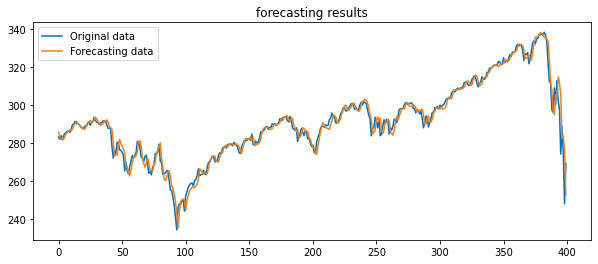

In [255]:
plot_all(pd.array(pred_Lasso[:]),PERIODS=400)

In [259]:
evl(SERIES[-400:].values, pred_Lasso)

Model Evaluation 
R2: 0.9599553922705836
RMSE: 3.9485914895096346
MAE: 2.424822208887241
MAPE: 0.8553158815302484


[0.9599553922705836, 3.9485914895096346, 2.424822208887241, 0.8553158815302484]

## 4.2linear regression 

In [260]:
pred_LR= []
for i in range(200,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        series = SERIES[:-i+1]
        pred_LR.append(step_linear_model(series,'LR'))
    elif (-i+1) == 0:
        series = SERIES
        pred_LR.append(step_linear_model(series,'LR'))

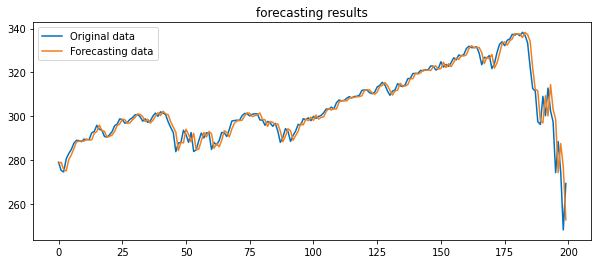

In [261]:
plot_all(pd.array(pred_LR[:]),PERIODS=200) 

In [262]:
evl(SERIES[-200:].values, pred_LR)

Model Evaluation 
R2: 0.9199235365097066
RMSE: 4.507306511878935
MAE: 2.5450175121704017
MAPE: 0.8614898207837703


[0.9199235365097066, 4.507306511878935, 2.5450175121704017, 0.8614898207837703]

## 4.3 Ridge

In [215]:
pred_Ridge= []
for i in range(100,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        series = SERIES[:-i+1]
        pred_Ridge.append(step_linear_model(series,'Ridge'))
    elif (-i+1) == 0:
        series = SERIES
        pred_Ridge.append(step_linear_model(series,'Ridge'))

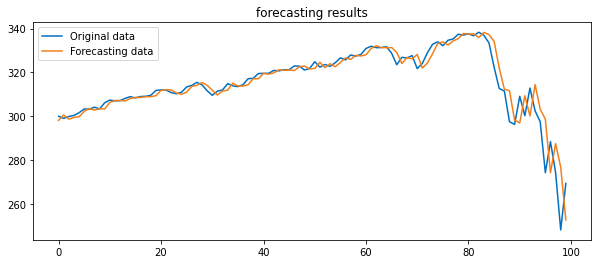

In [216]:
plot_all(pd.array(pred_Ridge[:]),PERIODS=100) 

In [217]:
evl(SERIES[-100:].values, pred_Ridge)

Model Evaluation 
R2: 0.8553655975609784
RMSE: 5.808572091337646
MAE: 3.0781738744531144
MAPE: 1.0331340702663305


[0.8553655975609784, 5.808572091337646, 3.0781738744531144, 1.0331340702663305]

# XGBOOST

In [276]:
from xgboost import XGBRegressor as XGBR
pred_Xgboost= []
for i in range(200,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        series = SERIES[:-i+1]
        pred_Xgboost.append(step_linear_model(series,'Xgboost'))
    elif (-i+1) == 0:
        series = SERIES
        pred_Xgboost.append(step_linear_model(series,'Xgboost'))

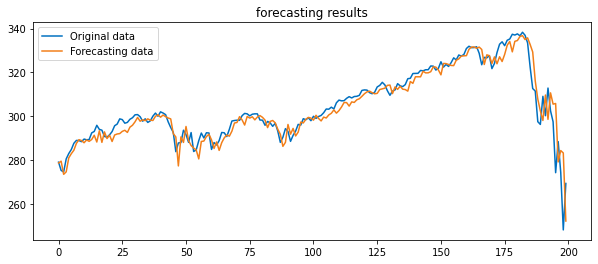

In [277]:
plot_all(pd.array(pred_Xgboost[:]),PERIODS=200) 

In [278]:
evl(SERIES[-200:].values, pred_Xgboost)

Model Evaluation 
R2: 0.8898320144698573
RMSE: 5.2867935849192
MAE: 3.263777313232422
MAPE: 1.0971188876309954


[0.8898320144698573, 5.2867935849192, 3.263777313232422, 1.0971188876309954]

# step by step prediction linear model

In [120]:
#without scaler
# DATE_BACK functions for inputting sets
def df_dateback(df,DATE_BACK=20,ahead = 1):
    trainX = df.drop('sum', axis=1, inplace=False)
    trainY = np.array(df['sum']).reshape(-1, 1)


    
    # Create dateback
    dataX, dataY = [], []
    ahead = ahead - 1
    for i in range(len(trainY)-DATE_BACK):
        dataX.append(np.array(trainX[i:(i+DATE_BACK)]))
        dataY.append(np.array(trainY[i+DATE_BACK]))
    dataX.append(np.array(trainX[-DATE_BACK:]))
        
    return np.array(dataX),np.array(dataY)

In [124]:
imfs['sum'] = SERIES.values
a,b = df_dateback(imfs,DATE_BACK=20,ahead = 1)

In [131]:
a.shape

(1981, 20, 8)

In [116]:
b.shape

(1980, 1)

# 1.emd resemble

In [218]:
def linear_model(df,periods,pre_days,model):
    trainX,trainY= df_dateback(df,ahead = pre_days)
    #print(type(trainX))
    X_train,X_test = trainX[:-periods],trainX[-periods:]
    y_train = trainY
    
    X_train = X_train.reshape(X_train.shape[0],-1)
    
    X_test = X_test.reshape(X_test.shape[0],-1)
    
    y_train = y_train.reshape(y_train.shape[0])
    
    #define linear model
    if model == 'LR':
        regressor = LinearRegression()
    if model =='Lasso':
        regressor = Lasso(alpha=0.1)
    if model == 'Ridge':
        regressor = Ridge()
        
    model = regressor.fit(X_train,y_train)
    #model = TransformedTargetRegressor(regressor= regressor,transformer = StandardScaler()).fit(X_train,y_train)
    
    # prediction on test set
    y_pred = model.predict(X_test)
    return y_pred

In [219]:
def one_step_pred(mode,series,model,recompose = False,redecom_model = 'ceemdan',denoise = False):
    MODE = mode
    imfs = emd_decom(series,draw = False)
    if recompose == False :
        if denoise == False:
            imfs['sum'] = series.values
            pred= linear_model(imfs,1,1,model)
        else :
            imfs.drop(axis = 1, columns = 'imf0',inplace = True)
            imfs['sum'] = series.values
            pred= linear_model(imfs,1,1,model)
    else :
        if denoise ==False:
            re_imfs = re_decom(imfs,redecom_mode=redecom_model,draw = False)
            re_imfs['sum'] = series.values
            pred= linear_model(re_imfs,1,1,model)
        else:
            if redecom_model != 'emd':
                re_imfs = re_decom(imfs,redecom_mode=redecom_model,draw = False)
                re_imfs.drop(axis = 1, columns = 'imf0-r'+redecom_model[:2]+'0',inplace = True)
                re_imfs['sum'] = series.values
                pred= linear_model(re_imfs,1,1,model)
            else:
                re_imfs = re_decom(imfs,redecom_mode=redecom_model,draw = False)
                re_imfs.drop(axis = 1, columns = 'imf0-r'+redecom_model[:1]+'0',inplace = True)
                re_imfs['sum'] = series.values
                pred= linear_model(re_imfs,1,1,model)
    
    return pred[0]

# LR

# 1.1EMD

In [225]:
type(imfs['imf0'])

pandas.core.series.Series

# 1.1.1 None

In [220]:
MODE = 'emd'
pred_1= []
for i in range(100,0,-1):
    print(100-i)
    series = SERIES[:-i]
    pred_1.append(one_step_pred('emd',series,model='LR',recompose = False,denoise = False))

0
EMD decomposition is running.
1
EMD decomposition is running.
2
EMD decomposition is running.
3
EMD decomposition is running.
4
EMD decomposition is running.
5
EMD decomposition is running.
6
EMD decomposition is running.
7
EMD decomposition is running.
8
EMD decomposition is running.
9
EMD decomposition is running.
10
EMD decomposition is running.
11
EMD decomposition is running.
12
EMD decomposition is running.
13
EMD decomposition is running.
14
EMD decomposition is running.
15
EMD decomposition is running.
16
EMD decomposition is running.
17
EMD decomposition is running.
18
EMD decomposition is running.
19
EMD decomposition is running.
20
EMD decomposition is running.
21
EMD decomposition is running.
22
EMD decomposition is running.
23
EMD decomposition is running.
24
EMD decomposition is running.
25
EMD decomposition is running.
26
EMD decomposition is running.
27
EMD decomposition is running.
28
EMD decomposition is running.
29
EMD decomposition is running.
30
EMD decomposition

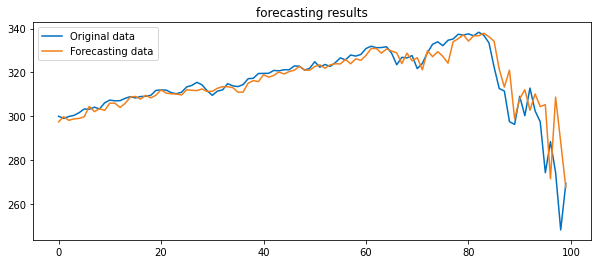

In [221]:
plot_all(pd.array(pred_1),PERIODS=100)

In [222]:
evl(SERIES[-100:].values, pred_1)

Model Evaluation 
R2: 0.7557439728842607
RMSE: 7.548422934463465
MAE: 3.7275625368806313
MAPE: 1.2540338883169662


[0.7557439728842607, 7.548422934463465, 3.7275625368806313, 1.2540338883169662]

# 1.1.2 emd + denoising

In [192]:
MODE = 'emd'
pred_2= []
for i in range(100,0,-1):
    print(100-i)
    series = SERIES[:-i]
    pred_2.append(one_step_pred('emd',series,model='LR',recompose = False,denoise = True))

0
EMD decomposition is running.
1
EMD decomposition is running.
2
EMD decomposition is running.
3
EMD decomposition is running.
4
EMD decomposition is running.
5
EMD decomposition is running.
6
EMD decomposition is running.
7
EMD decomposition is running.
8
EMD decomposition is running.
9
EMD decomposition is running.
10
EMD decomposition is running.
11
EMD decomposition is running.
12
EMD decomposition is running.
13
EMD decomposition is running.
14
EMD decomposition is running.
15
EMD decomposition is running.
16
EMD decomposition is running.
17
EMD decomposition is running.
18
EMD decomposition is running.
19
EMD decomposition is running.
20
EMD decomposition is running.
21
EMD decomposition is running.
22
EMD decomposition is running.
23
EMD decomposition is running.
24
EMD decomposition is running.
25
EMD decomposition is running.
26
EMD decomposition is running.
27
EMD decomposition is running.
28
EMD decomposition is running.
29
EMD decomposition is running.
30
EMD decomposition

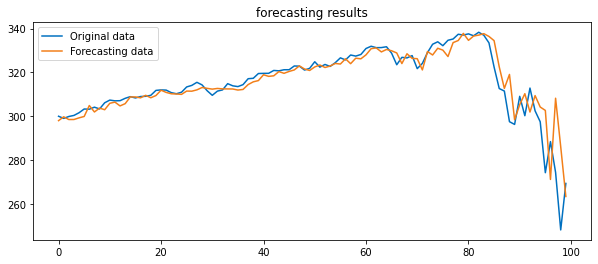

In [193]:
plot_all(pd.array(pred_2),PERIODS=100) 

In [194]:
evl(SERIES[-100:].values, pred_2)

Model Evaluation 
R2: 0.7779436831427955
RMSE: 7.197226114348469
MAE: 3.5734349408500368
MAPE: 1.204888207930258


[0.7779436831427955, 7.197226114348469, 3.5734349408500368, 1.204888207930258]

## 1.2 EMD + recompose

## 1.2.1 EMD+ None

In [195]:
pred_3= []
for i in range(100,0,-1):
    print(100-i)
    series = SERIES[:-i]
    pred_3.append(one_step_pred('emd',series,model='LR',recompose = True,
                                    redecom_model = 'emd',denoise = False))

0
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
1
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
2
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
3
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
4
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
5
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
6
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
7
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
8
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
9
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.


82
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
83
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
84
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
85
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
86
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
87
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
88
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
89
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
90
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
91
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is

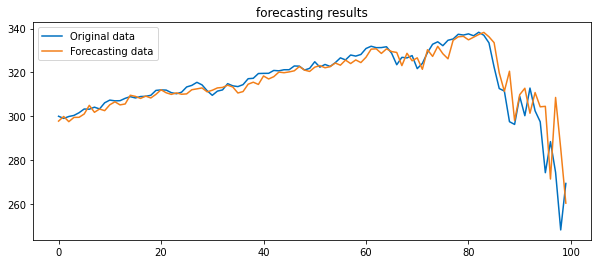

In [175]:
plot_all(pd.array(pred_3),PERIODS=100) 

In [176]:
evl(SERIES[-100:].values, pred_3)

Model Evaluation 
R2: 0.7662506994659342
RMSE: 7.38428994563202
MAE: 3.7152891508235295
MAPE: 1.2513612461873878


[0.7662506994659342, 7.38428994563202, 3.7152891508235295, 1.2513612461873878]

## 1.2.2 EMD + EMD + denoise

In [196]:
pred_4= []
for i in range(100,0,-1):
    print(100-i)
    series = SERIES[:-i]
    pred_4.append(one_step_pred('emd',series,model='LR',recompose = True,
                                    redecom_model = 'emd',denoise = True))

0
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
1
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
2
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
3
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
4
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
5
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
6
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
7
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
8
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
9
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.


Re-decomposition is running for imf0.
EMD decomposition is running.
83
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
84
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
85
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
86
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
87
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
88
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
89
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
90
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
91
EMD decomposition is running.
Re-decomposition is running for imf0.
EMD decomposition is running.
92
EMD decomposition is

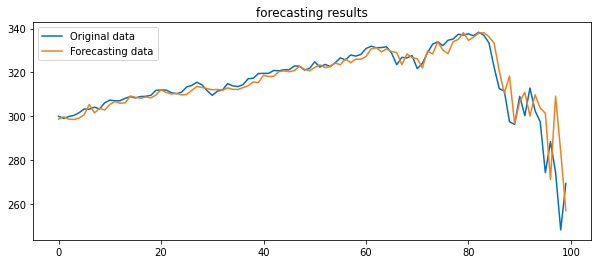

In [197]:
plot_all(pd.array(pred_4),PERIODS=100)

In [198]:
evl(SERIES[-100:].values, pred_4)

Model Evaluation 
R2: 0.7844285030927466
RMSE: 7.09135536946368
MAE: 3.4780073517238064
MAPE: 1.1760645856435623


[0.7844285030927466, 7.09135536946368, 3.4780073517238064, 1.1760645856435623]

## 1.3 emd + eemd

# None

In [76]:
pred_5= []
for i in range(100):
    n = 99-i
    print(i)
    if n!=0:
        series = SERIES[:-n]
        pred_5.append(one_step_pred('emd',series,model='LR',recompose = True,
                                    redecom_model = 'eemd',denoise = False))
    elif n==0:
        series = SERIES
        pred_5.append(one_step_pred('emd',series,model = 'LR',recompose = True,
                                    redecom_model = 'eemd',denoise = False))

0
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
1
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
2
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
3
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
4
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
5
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
6
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
7
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
8
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
9
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is

81
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
82
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
83
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
84
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
85
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
86
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
87
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
88
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
89
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
90
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomp

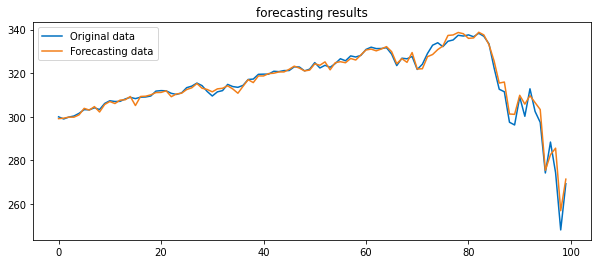

In [77]:
plot_all(pd.array(pred_5),PERIODS=100)

In [78]:
evl(SERIES[-100:].values, pred_5)

Model Evaluation 
R2: 0.9771714963054907
RMSE: 2.3076625609758024
MAE: 1.4432288554455897
MAPE: 0.4739542286559699


[0.9771714963054907,
 2.3076625609758024,
 1.4432288554455897,
 0.4739542286559699]

## denoising

In [82]:
pred_6= []
for i in range(100):
    n = 99-i
    print(i)
    if n!=0:
        series = SERIES[:-n]
        pred_6.append(one_step_pred('emd',series,model='LR',recompose = True,
                                    redecom_model = 'eemd',denoise = True))
    elif n==0:
        series = SERIES
        pred_6.append(one_step_pred('emd',series,model = 'LR',recompose = True,
                                    redecom_model = 'eemd',denoise = True))

0
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
1
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
2
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
3
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
4
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
5
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
6
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
7
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
8
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
9
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is

81
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
82
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
83
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
84
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
85
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
86
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
87
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
88
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
89
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomposition is running.
90
EMD decomposition is running.
Re-decomposition is running for imf0.
EEMD decomp

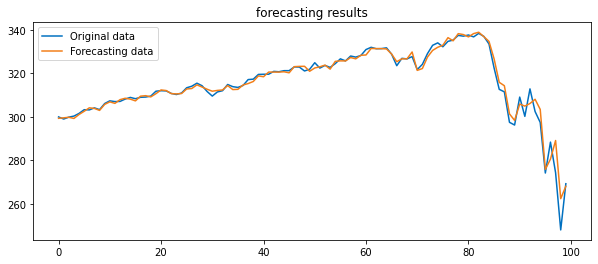

In [83]:
plot_all(pd.array(pred_6),PERIODS=100)

In [84]:
evl(SERIES[-100:].values, pred_6)

Model Evaluation 
R2: 0.9667403648563079
RMSE: 2.7854304656979
MAE: 1.4944781562967393
MAPE: 0.49769330417892943


[0.9667403648563079, 2.7854304656979, 1.4944781562967393, 0.49769330417892943]

# EMD + ceemdan

# None

In [93]:
pred_7= []
for i in range(100):
    n = 99-i
    print(i)
    if n!=0:
        series = SERIES[:-n]
        pred_7.append(one_step_pred('emd',series,model='LR',recompose = True,
                                    redecom_model = 'ceemdan',denoise = False))
    elif n==0:
        series = SERIES
        pred_7.append(one_step_pred('emd',series,model = 'LR',recompose = True,
                                    redecom_model = 'ceemdan',denoise = False))

0
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
1
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
2
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
3
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
4
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
5
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
6
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
7
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
8
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
9
CEEMDAN decomposition is r

Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
76
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
77
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
78
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
79
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
80
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
81
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
82
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
83
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
84
CEEMDAN decomposition is running.
Re-decomposition is

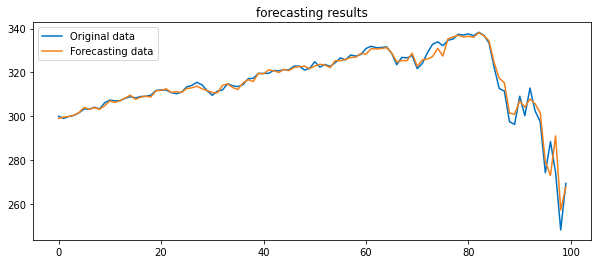

In [94]:
plot_all(pd.array(pred_7),PERIODS=100)

In [95]:
evl(SERIES[-100:].values, pred_7)

Model Evaluation 
R2: 0.9608340281845186
RMSE: 3.0226512004344075
MAE: 1.5953843978745965
MAPE: 0.5279027071987797


[0.9608340281845186,
 3.0226512004344075,
 1.5953843978745965,
 0.5279027071987797]

## denoise

In [90]:
pred_8= []
for i in range(100):
    n = 99-i
    print(i)
    if n!=0:
        series = SERIES[:-n]
        pred_8.append(one_step_pred('emd',series,model='LR',recompose = True,
                                    redecom_model = 'ceemdan',denoise = True))
    elif n==0:
        series = SERIES
        pred_8.append(one_step_pred('emd',series,model = 'LR',recompose = True,
                                    redecom_model = 'ceemdan',denoise = True))

0
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
1
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
2
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
3
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
4
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
5
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
6
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
7
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
8
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
9
CEEMDAN decomposition is r

Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
76
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
77
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
78
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
79
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
80
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
81
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
82
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
83
CEEMDAN decomposition is running.
Re-decomposition is running for imf0.
CEEMDAN decomposition is running.
84
CEEMDAN decomposition is running.
Re-decomposition is

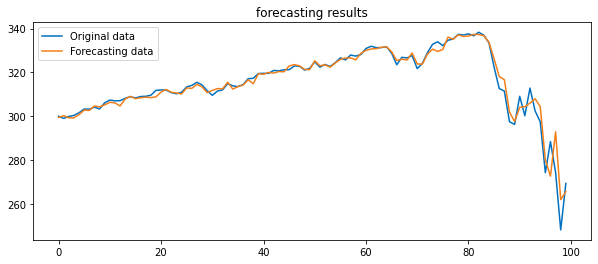

In [91]:
plot_all(pd.array(pred_8),PERIODS=100)

In [92]:
evl(SERIES[-100:].values, pred_8)

Model Evaluation 
R2: 0.9486391833594967
RMSE: 3.461382082296433
MAE: 1.7975307374387866
MAPE: 0.6017281842556323


[0.9486391833594967, 3.461382082296433, 1.7975307374387866, 0.6017281842556323]

In [219]:
def denoised_one_step_pred(mode,series,model):
    MODE = mode
    imfs = emd_decom(series,draw = False)
    imfs['sum'] = series.values
    imfs.drop(axis = 1, columns = 'imf0',inplace = True)
    start = time.time()
    pred= linear_model(imfs,1,1,model)
    end = time.time()
    print('Running time: %.3fs'%(end-start))
    return pred[0]

In [220]:
denoise_pred0_100= []
for i in range(100):
    n = 99-i
    #print(i)
    if n!=0:
        series = SERIES[:-n]
        keras.backend.clear_session()
        denoise_pred0_100.append(denoised_one_step_pred('emd',series,'LR'))
    elif n==0:
        series = SERIES
        keras.backend.clear_session()
        denoise_pred0_100.append(denoised_one_step_pred('emd',series,'LR'))

EMD decomposition is running.
Running time: 0.047s
EMD decomposition is running.
Running time: 0.047s
EMD decomposition is running.
Running time: 0.049s
EMD decomposition is running.
Running time: 0.048s
EMD decomposition is running.
Running time: 0.044s
EMD decomposition is running.
Running time: 0.046s
EMD decomposition is running.
Running time: 0.044s
EMD decomposition is running.
Running time: 0.047s
EMD decomposition is running.
Running time: 0.058s
EMD decomposition is running.
Running time: 0.044s
EMD decomposition is running.
Running time: 0.043s
EMD decomposition is running.
Running time: 0.043s
EMD decomposition is running.
Running time: 0.045s
EMD decomposition is running.
Running time: 0.043s
EMD decomposition is running.
Running time: 0.045s
EMD decomposition is running.
Running time: 0.049s
EMD decomposition is running.
Running time: 0.044s
EMD decomposition is running.
Running time: 0.045s
EMD decomposition is running.
Running time: 0.048s
EMD decomposition is running.
R

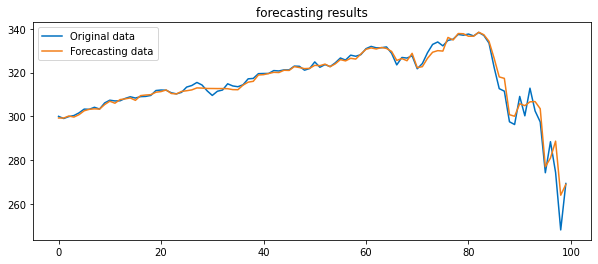

In [188]:
plot_all(pd.array(denoise_pred0_100),PERIODS=100)

In [185]:
evl(SERIES[-100:].values, denoise_pred0_100)

Model Evaluation 
R2: 0.9627811929215044
RMSE: 2.9465567208285126
MAE: 1.6199642090080033
MAPE: 0.5385668847031861


[0.9627811929215044,
 2.9465567208285126,
 1.6199642090080033,
 0.5385668847031861]

# Calculate sample

In [ ]:
import numpy as np
import fathon
from fathon import fathonUtils as fu

#time series
a = np.random.randn(10000)

#zero-mean cumulative sum
a = fu.toAggregated(a)

#initialize dfa object
pydfa = fathon.DFA(a)
#compute fluctuation function and Hurst exponent
wins = fu.linRangeByStep(1, 200)
n, F = pydfa.computeFlucVec(wins, revSeg=True, polOrd=3)
H, H_intercept = pydfa.fitFlucVec()

#compute Hurst exponent in different ranges
#limits_list = np.array([[15,2000], [200,1000]], dtype=int)
#list_H, list_H_intercept = pydfa.multiFitFlucVec(limits_list)